In [2]:
import pandas as pd
data = pd.read_excel('C:/Users/86181/Desktop/nipt_processed.xlsx')
male_df = data[data['性别'] == 1].copy()

原始数据分组统计：
       count   mean  median    min    max   var
BMI分组                                          
正常         4  20.70   20.70  20.70  20.70  0.00
肥胖       857  33.18   32.71  30.00  46.88  6.88
超重       221  29.04   29.14  26.62  30.00  0.46


C:\Users\86181\AppData\Local\Temp\ipykernel_15752\3523238278.py:40: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\3523238278.py:40: UserWarning: Glyph 31665 (\N{CJK UNIFIED IDEOGRAPH-7BB1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\3523238278.py:40: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\3523238278.py:40: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\3523238278.py:40: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\3523238278.py:40: UserWarning: Glyph 25968 (\

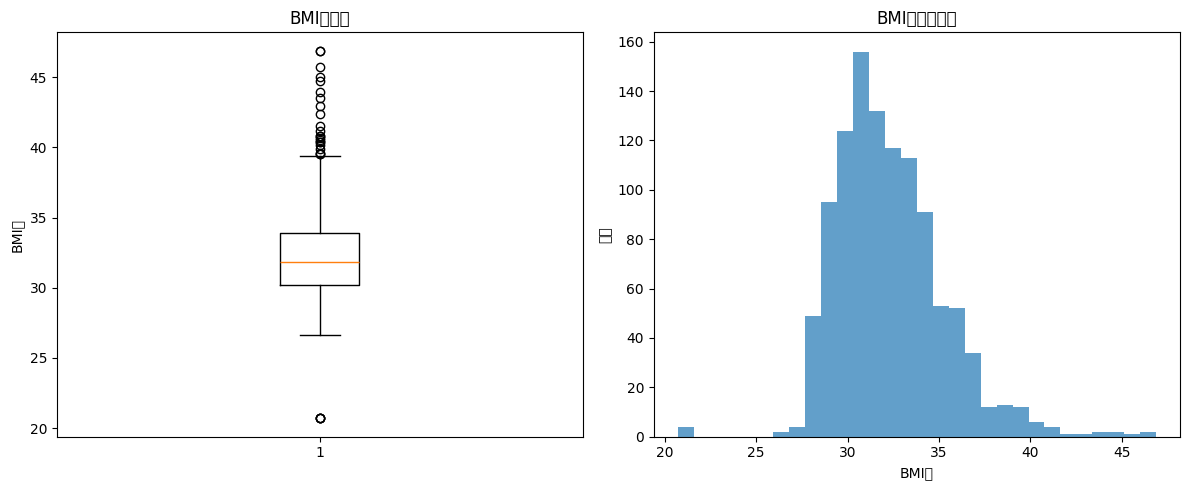

检测到 26 个异常值

删除异常值后分组统计：
       count   mean  median    min    max   var
BMI分组                                          
肥胖       835  32.95   32.60  30.00  39.35  4.75
超重       221  29.04   29.14  26.62  30.00  0.46

删除前后对比：
       删除前样本数  删除后样本数  删除前均值  删除后均值
BMI分组                              
正常          4     NaN  20.70    NaN
肥胖        857   835.0  33.18  32.95
超重        221   221.0  29.04  29.04


C:\Users\86181\AppData\Local\Temp\ipykernel_15752\3523238278.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df_clean['BMI分组'] = male_df_clean['孕妇BMI'].apply(classify_bmi)


In [3]:
# 第一步：BMI分组、数据统计、异常值处理
import numpy as np
import matplotlib.pyplot as plt

# BMI分组函数
def classify_bmi(bmi):
    if bmi < 18.5:
        return '偏瘦'
    elif bmi < 25.0:
        return '正常'
    elif bmi < 30.0:
        return '超重'
    else:
        return '肥胖'

# 原始数据分组
male_df['BMI分组'] = male_df['孕妇BMI'].apply(classify_bmi)

# 原始数据统计
print("原始数据分组统计：")
original_stats = male_df.groupby('BMI分组')['孕妇BMI'].agg([
    'count', 'mean', 'median', 'min', 'max', 'var'
]).round(2)
print(original_stats)

# 可视化查看异常值
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 箱线图
axes[0].boxplot(male_df['孕妇BMI'])
axes[0].set_ylabel('BMI值')
axes[0].set_title('BMI箱线图')

# 直方图
axes[1].hist(male_df['孕妇BMI'], bins=30, alpha=0.7)
axes[1].set_xlabel('BMI值')
axes[1].set_ylabel('频数')
axes[1].set_title('BMI分布直方图')

plt.tight_layout()
plt.show()

# 异常值检测和删除
Q1 = male_df['孕妇BMI'].quantile(0.25)
Q3 = male_df['孕妇BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = male_df[(male_df['孕妇BMI'] < lower_bound) | (male_df['孕妇BMI'] > upper_bound)]
print(f"检测到 {len(outliers)} 个异常值")

# 删除异常值
male_df_clean = male_df[(male_df['孕妇BMI'] >= lower_bound) & (male_df['孕妇BMI'] <= upper_bound)]
male_df_clean['BMI分组'] = male_df_clean['孕妇BMI'].apply(classify_bmi)

# 处理后数据统计
print("\n删除异常值后分组统计：")
cleaned_stats = male_df_clean.groupby('BMI分组')['孕妇BMI'].agg([
    'count', 'mean', 'median', 'min', 'max', 'var'
]).round(2)
print(cleaned_stats)

# 删除前后对比
print("\n删除前后对比：")
comparison = pd.DataFrame({
    '删除前样本数': original_stats['count'],
    '删除后样本数': cleaned_stats['count'],
    '删除前均值': original_stats['mean'],
    '删除后均值': cleaned_stats['mean']
})
print(comparison)

In [4]:
# 第二步：建立带交互项的多项式回归模型
import statsmodels.api as sm

print("\n第二步：建立多项式回归模型")

# 使用清洁数据
df = male_df_clean.copy()

# 查找Y染色体浓度列
y_col = None
for col in df.columns:
    if 'Y染色体' in col or 'Y' in col or '浓度' in col:
        y_col = col
        break

# 查找孕周列
gestational_col = None
for col in df.columns:
    if '孕周' in col or '周数' in col or 'week' in col.lower():
        gestational_col = col
        break

if y_col and gestational_col:
    # 提取变量
    y = df[y_col].copy()
    x1_raw = df[gestational_col].copy()
    x2 = df['孕妇BMI'].copy()
    
    # 处理孕周数据
    if x1_raw.dtype == 'object':
        x1 = pd.to_numeric(x1_raw.astype(str).str.extract('(\d+\.?\d*)')[0], errors='coerce')
    else:
        x1 = pd.to_numeric(x1_raw, errors='coerce')
    
    # 删除缺失值
    valid_mask = ~(y.isna() | x1.isna() | x2.isna())
    y_clean = y[valid_mask]
    x1_clean = x1[valid_mask]
    x2_clean = x2[valid_mask]
    
    print(f"有效样本数：{len(y_clean)}")
    
    # 构建特征矩阵
    X = pd.DataFrame({
        '孕周': x1_clean,
        '孕周平方': x1_clean ** 2,
        'BMI': x2_clean,
        '孕周BMI交互': x1_clean * x2_clean
    })
    
    # 拟合模型
    X_sm = sm.add_constant(X)
    model = sm.OLS(y_clean, X_sm).fit()
    
    print("\n模型结果：")
    print(model.summary())
    
    # 提取回归系数
    coefficients = model.params
    print(f"\n回归方程：")
    print(f"Y = {coefficients['const']:.6f} + {coefficients['孕周']:.6f}*孕周 + {coefficients['孕周平方']:.8f}*孕周² + {coefficients['BMI']:.6f}*BMI + {coefficients['孕周BMI交互']:.8f}*孕周*BMI")
    
    # 显著性检验
    print(f"\n显著性检验：")
    for var in X_sm.columns:
        p_val = model.pvalues[var]
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"{var}: p值={p_val:.3e} {significance}")
    
    # 保存系数
    beta0 = coefficients['const']
    beta1 = coefficients['孕周']
    beta2 = coefficients['孕周平方']
    beta3 = coefficients['BMI']
    beta4 = coefficients['孕周BMI交互']
    
    print(f"\nR² = {model.rsquared:.4f}")

else:
    print("未找到必要的列")


第二步：建立多项式回归模型
有效样本数：1056

模型结果：
                            OLS Regression Results                            
Dep. Variable:                Y染色体的Z值   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.874
Date:                Sat, 06 Sep 2025   Prob (F-statistic):           0.000676
Time:                        13:18:34   Log-Likelihood:                -1752.9
No. Observations:                1056   AIC:                             3516.
Df Residuals:                    1051   BIC:                             3541.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.17

In [5]:
# 第三步和第四步：阈值计算和最佳NIPT时点确定
import math

print("\n第三步：基于阈值0.04求解孕周")

if 'beta0' in locals():
    # BMI分组上限值
    bmi_limits = {
        '偏瘦': 18.4,
        '正常': 24.9,
        '超重': 29.9,
        '肥胖': 40.0
    }
    
    def solve_gestational_week(bmi_value, target_y=0.04):
        # 求解二次方程：beta2*week² + (beta1 + beta4*BMI)*week + (beta0 + beta3*BMI - target_y) = 0
        a = beta2
        b = beta1 + beta4 * bmi_value
        c = beta0 + beta3 * bmi_value - target_y
        
        discriminant = b**2 - 4*a*c
        
        if discriminant < 0:
            return None
        
        week1 = (-b + math.sqrt(discriminant)) / (2*a)
        week2 = (-b - math.sqrt(discriminant)) / (2*a)
        
        # 选择合理的正值解
        solutions = [w for w in [week1, week2] if w > 0 and w < 45]
        return min(solutions) if solutions else None
    
    results_04 = {}
    
    for group, bmi_limit in bmi_limits.items():
        theoretical_week = solve_gestational_week(bmi_limit)
        if theoretical_week:
            rounded_week = math.ceil(theoretical_week)
            final_week = rounded_week + 1
            
            results_04[group] = {
                'BMI上限': bmi_limit,
                '理论孕周': theoretical_week,
                '向上取整': rounded_week,
                '最佳时点': final_week
            }
            
            print(f"{group}组 (BMI≤{bmi_limit}): 理论{theoretical_week:.2f}周 → 取整{rounded_week}周 → 最佳{final_week}周")
    
    print("\n第四步：最佳NIPT时点汇总")
    nipt_schedule = pd.DataFrame(results_04).T
    print(nipt_schedule.round(2))

else:
    print("模型系数未定义")


第三步：基于阈值0.04求解孕周
偏瘦组 (BMI≤18.4): 理论6.22周 → 取整7周 → 最佳8周
正常组 (BMI≤24.9): 理论9.38周 → 取整10周 → 最佳11周
超重组 (BMI≤29.9): 理论11.69周 → 取整12周 → 最佳13周
肥胖组 (BMI≤40.0): 理论14.26周 → 取整15周 → 最佳16周

第四步：最佳NIPT时点汇总
    BMI上限   理论孕周  向上取整  最佳时点
偏瘦   18.4   6.22   7.0   8.0
正常   24.9   9.38  10.0  11.0
超重   29.9  11.69  12.0  13.0
肥胖   40.0  14.26  15.0  16.0



第五步：检测误差灵敏度分析
严格阈值4.5%下的计算结果：
偏瘦组 (BMI≤18.4): 理论6.11周 → 取整7周 → 最佳8周
正常组 (BMI≤24.9): 理论9.20周 → 取整10周 → 最佳11周
超重组 (BMI≤29.9): 理论11.42周 → 取整12周 → 最佳13周
肥胖组 (BMI≤40.0): 理论13.99周 → 取整14周 → 最佳15周

灵敏度分析对比表：
  BMI分组  BMI上限  4.0%阈值最佳时点  4.5%阈值最佳时点  时点差异
0    偏瘦   18.4           8           8     0
1    正常   24.9          11          11     0
2    超重   29.9          13          13     0
3    肥胖   40.0          16          15    -1


C:\Users\86181\AppData\Local\Temp\ipykernel_15752\87525051.py:59: UserWarning: Glyph 20559 (\N{CJK UNIFIED IDEOGRAPH-504F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\87525051.py:59: UserWarning: Glyph 30246 (\N{CJK UNIFIED IDEOGRAPH-7626}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\87525051.py:59: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\87525051.py:59: UserWarning: Glyph 24120 (\N{CJK UNIFIED IDEOGRAPH-5E38}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\87525051.py:59: UserWarning: Glyph 36229 (\N{CJK UNIFIED IDEOGRAPH-8D85}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\86181\AppData\Local\Temp\ipykernel_15752\87525051.py:59: UserWarning: Glyph 37325 (\N{CJK UNIFIE

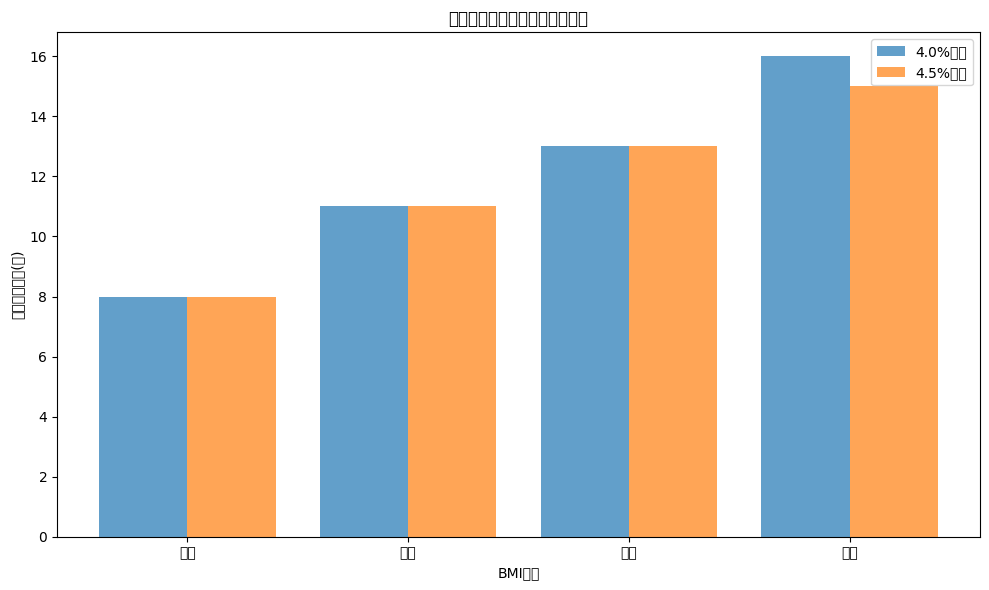


分析总结：
考虑检测误差后，检测时点平均延后-0.2周
各BMI组推荐检测时点：
偏瘦组: 4.0%阈值-8周, 4.5%阈值-8周
正常组: 4.0%阈值-11周, 4.5%阈值-11周
超重组: 4.0%阈值-13周, 4.5%阈值-13周
肥胖组: 4.0%阈值-16周, 4.5%阈值-15周


In [6]:
# 第五步：检测误差灵敏度分析
print("\n第五步：检测误差灵敏度分析")

if 'beta0' in locals() and 'results_04' in locals():
    # 严格阈值4.5%
    results_045 = {}
    
    print("严格阈值4.5%下的计算结果：")
    
    for group, bmi_limit in bmi_limits.items():
        theoretical_week = solve_gestational_week(bmi_limit, 0.045)
        if theoretical_week:
            rounded_week = math.ceil(theoretical_week)
            final_week = rounded_week + 1
            
            results_045[group] = {
                'BMI上限': bmi_limit,
                '理论孕周': theoretical_week,
                '向上取整': rounded_week,
                '最佳时点': final_week
            }
            
            print(f"{group}组 (BMI≤{bmi_limit}): 理论{theoretical_week:.2f}周 → 取整{rounded_week}周 → 最佳{final_week}周")
    
    # 对比分析表
    print("\n灵敏度分析对比表：")
    
    comparison_table = []
    for group in bmi_limits.keys():
        if group in results_04 and group in results_045:
            row = {
                'BMI分组': group,
                'BMI上限': bmi_limits[group],
                '4.0%阈值最佳时点': results_04[group]['最佳时点'],
                '4.5%阈值最佳时点': results_045[group]['最佳时点'],
                '时点差异': results_045[group]['最佳时点'] - results_04[group]['最佳时点']
            }
            comparison_table.append(row)
    
    comparison_df = pd.DataFrame(comparison_table)
    print(comparison_df)
    
    # 可视化对比
    fig, ax = plt.subplots(figsize=(10, 6))
    
    groups = comparison_df['BMI分组']
    x_pos = np.arange(len(groups))
    
    ax.bar(x_pos - 0.2, comparison_df['4.0%阈值最佳时点'], 0.4, label='4.0%阈值', alpha=0.7)
    ax.bar(x_pos + 0.2, comparison_df['4.5%阈值最佳时点'], 0.4, label='4.5%阈值', alpha=0.7)
    
    ax.set_xlabel('BMI分组')
    ax.set_ylabel('推荐检测时点(周)')
    ax.set_title('不同阈值下的推荐检测时点对比')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(groups)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 分析总结
    print("\n分析总结：")
    avg_delay = comparison_df['时点差异'].mean()
    print(f"考虑检测误差后，检测时点平均延后{avg_delay:.1f}周")
    print("各BMI组推荐检测时点：")
    for _, row in comparison_df.iterrows():
        print(f"{row['BMI分组']}组: 4.0%阈值-{row['4.0%阈值最佳时点']}周, 4.5%阈值-{row['4.5%阈值最佳时点']}周")

else:
    print("前续步骤未完成")